# Using mtSet in python

Multi Trait Set test is an implementation of efficient set test algorithms for testing for associations between multiple genetic variants and multiple traits.
mtSet can account for confounding factors such as relatedness and can be used for analysis of single traits. A detailed description of the method can be found at [1].

Below we show how to to use mtSet within python.
For a tutorial on how to use mtSet from the command line using the limix scripts (mtSet_preprocess, mtSet_analyze, mtSet_postprocess, mtSet_simPheno) please refer to [this tutorial](mtSet_commandline.ipynb).

### Setting up

In [1]:
%matplotlib inline

import scipy as sp
import scipy.linalg
from limix.data import BedReader
from limix.util import sets_from_bim
from limix.mtSet import MTSet
from limix.util import unique_variants

#### Download the data

In [2]:
# loading 1000G genotypes for mtSet demo
from download_examples import get_1000G_mtSet
get_1000G_mtSet()

#### Import Genotype data

We here use the class ``limix.bed.reader`` to read and query bed files. See [here][1] for more info.
[1]:http://limix.readthedocs.io/data.html#limix.data.BedReader

In [3]:
# import bed file
bfile = 'data/1000G/chrom22_subsample20_maf0.10'
reader = BedReader(bfile)
bim = reader.getSnpInfo()

#### Defines variant-sets

In [4]:
# defines sets using a sliding-window approach.
# window size = 50kb
# step = 25kb
# exclude regions with less than 4 variants.
sets = sets_from_bim(bim, size=50000, step=25000, minSnps=4)
print sets.head()

                  setid chrom     start       end nsnps
0  22:16050612-16100612    22  16050612  16100612    23
1  22:16100612-16150612    22  16100612  16150612     4
2  22:16125612-16175612    22  16125612  16175612     7
3  22:16225612-16275612    22  16225612  16275612     9
4  22:16250612-16300612    22  16250612  16300612    16


### Apply

In this section we showcase how to construct the mtSet class that will then be used for the set test analysis. We showcase both the full mtSet that models relatedness as random effect by the means of an individual-to-individual covariance matrix and the approximated model (mtSetPC) that models relatedness as fixed effect using principal component from the covariance.

The limix class for multi-trait set tests is ``limix.mtSet.MTSet`` (see [here][1] for the documentation).

[1]:http://limix.readthedocs.io/mtSet.html

In [5]:
# import phenotype and sample relatedness
pheno_file = './data/1000g/pheno.phe'
sample_relatedness_file = './data/1000g/chrom22.cov'
Y = sp.loadtxt(pheno_file)
R = sp.loadtxt(sample_relatedness_file)

In [6]:
# compute eigenvalues and eigenvectors of the sample relatedness matrix
S_R, U_R = scipy.linalg.eigh(R) # these are needed for the full mtSet model

In [7]:
# caculate fixed effects with rel
F = U_R[:, ::-1][:, :10] # it considered the first 10 PCs
F = sp.concatenate([F, sp.ones((F.shape[0], 1))], 1) # add an intercept term

In [8]:
if 0:
    # use full mtSet implementation
    # (relatedness is modeled as random effect by the means of
    # an individual-to-individual covariance matrix)
    mtSet = MTSet(Y, S_R=S_R, U_R=U_R)
else:
    # use mtSetPC
    # (relatedness s modelled as fixed effect
    # using principal component from the covariance)
    mtSet = MTSet(Y, F=F)

### Null model

If the analysis is parallelized across different set of regions and permutations,
it might be convenient to cache the results from the optimization of the null model
(as the null model need to be optimized only once).

| Argument        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| __cache__       | False | bool | If true, it activates the caching |
| __out\_dir__     | './cache' | str | outdir of the cache file |
| __fname__       | None | str | Name of the file |
| __rewrite__     | False | bool | If true and the cache file already exists, the cache file is overwritten |

In [9]:
RV = mtSet.fitNull()

The returned dictionary contains:
* __B__: value of the optimized effect sizes
* __Cg__: value of the genetic trait-to-trait covariance
* __Cn__: value of the residual trait-to-trait covariance
* __conv__: bool that indicates convergence of the optimization
* __time__: time elpased for optimizing the parameters
* __NLL0__: negative log likelihood of the null model
* __LMLgrad__: norm of the gradient of the negative log likelihood dividived by the number of parameters

### Test

In [13]:
n_wnds = 100 # only hundred windows are considered
LLR = sp.zeros(n_wnds) # vector with test statistics of the n_wnds regions

iter_sets = sets.iterrows()
for wnd_i in range(n_wnds):

    # extract geno info
    _, set = next(iter_sets)
    print('.. set %d: %s' % (wnd_i, set['setid']))
    
    Xr = reader.getGenotypes(pos_start=set['start'],
                             pos_end=set['end'],
                             chrom=set['chrom'],
                             impute=True)
    
    # unique variants and standardize
    Xr = unique_variants(Xr)
    Xr-= Xr.mean(0); Xr/= Xr.std(0)

    # multi trait set test fit
    RV = mtSet.optimize(Xr)
    LLR[wnd_i] = RV['LLR'][0]

.. set 0: 22:16050612-16100612
.. set 1: 22:16100612-16150612
.. set 2: 22:16125612-16175612
.. set 3: 22:16225612-16275612
.. set 4: 22:16250612-16300612
.. set 5: 22:16275612-16325612
.. set 6: 22:16300612-16350612
.. set 7: 22:16325612-16375612
.. set 8: 22:16350612-16400612
.. set 9: 22:16475612-16525612
.. set 10: 22:16500612-16550612
.. set 11: 22:16525612-16575612
.. set 12: 22:16550612-16600612
.. set 13: 22:16575612-16625612
.. set 14: 22:16600612-16650612
.. set 15: 22:16625612-16675612
.. set 16: 22:16650612-16700612
.. set 17: 22:16675612-16725612
.. set 18: 22:16825612-16875612
.. set 19: 22:16850612-16900612
.. set 20: 22:16875612-16925612
.. set 21: 22:16900612-16950612
.. set 22: 22:16925612-16975612
.. set 23: 22:16950612-17000612
.. set 24: 22:16975612-17025612
.. set 25: 22:17000612-17050612
.. set 26: 22:17025612-17075612
.. set 27: 22:17050612-17100612
.. set 28: 22:17075612-17125612
.. set 29: 22:17100612-17150612
.. set 30: 22:17125612-17175612
.. set 31: 22:1715

The returned dictionary from _mtSet.optimize_ contains:
* __Cr__: value of the region-term trait-to-trait covariance
* __Cg__: value of the genetic trait-to-trait covariance
* __Cn__: value of the residual trait-to-trait covariance
* __variances__: n_traits-by-3 matrix of variance explained by the three contributions (region, background, noise) for the  traits
* __conv__: bool that indicates convergence of the optimization
* __time__: time elpased for optimizing the parameters
* __NLLAlt__: negative log likelihood of the alternative model
* __LLR__: test statistics
* __LMLgrad__: norm of the gradient of the negative log likelihood dividived by the number of parameters

### P-values

P values are obtained from a relatively small number of genome-wide permutations, fitting a parametric model to the null distribution. Here we showcase the permutation procedure by considering 10 permutations for the 10 regions analyzed.

In [25]:
n_perms = 5
LLR_null = [] # in this list test statistics from permutations will be stored
for perm_i in range(n_perms):
    
    #1. generate permutation
    print 'permutation %d' % perm_i
    sp.random.seed(perm_i)
    perm_idxs = sp.random.permutation(Y.shape[0])
    
    #2. scan on the 100 regions
    for wnd_i in range(n_wnds):

        # extract geno info
        _, set = next(iter_sets)
        print('.. set %d: %s' % (wnd_i, set['setid']))

        Xr = reader.getGenotypes(pos_start=set['start'],
                         pos_end=set['end'],
                         chrom=set['chrom'],
                         impute=True)
        
        # unique variants and standardize
        Xr = unique_variants(Xr)
        Xr-= Xr.mean(0); Xr/= Xr.std(0)

        # permute
        Xr = Xr[perm_idxs, :] # permute samples in region term
        
        # fit mtSet
        RV = mtSet.optimize(Xr)
        LLR_null.append(RV['LLR'][0])
        
LLR_null = sp.array(LLR_null)

permutation 0
.. set 0: 22:24100612-24150612
.. set 1: 22:24125612-24175612
.. set 2: 22:24150612-24200612
.. set 3: 22:24175612-24225612
.. set 4: 22:24200612-24250612
.. set 5: 22:24225612-24275612
.. set 6: 22:24250612-24300612
.. set 7: 22:24275612-24325612
.. set 8: 22:24300612-24350612
.. set 9: 22:24325612-24375612
.. set 10: 22:24350612-24400612
.. set 11: 22:24375612-24425612
.. set 12: 22:24400612-24450612
.. set 13: 22:24425612-24475612
.. set 14: 22:24450612-24500612
.. set 15: 22:24475612-24525612
.. set 16: 22:24500612-24550612
.. set 17: 22:24525612-24575612
.. set 18: 22:24550612-24600612
.. set 19: 22:24575612-24625612
.. set 20: 22:24600612-24650612
.. set 21: 22:24625612-24675612
.. set 22: 22:24650612-24700612
.. set 23: 22:24675612-24725612
.. set 24: 22:24700612-24750612
.. set 25: 22:24725612-24775612
.. set 26: 22:24750612-24800612
.. set 27: 22:24775612-24825612
.. set 28: 22:24800612-24850612
.. set 29: 22:24825612-24875612
.. set 30: 22:24850612-24900612
.. s

The parametric fit to the ditribution of the test statistics under the null and the consequent conversion of the observed test statistics in P values is performed by the module ``limix.stats.chi2mixture`` (see [here][1]) as shown below.

[1]:http://limix.readthedocs.io/stats.html#limix.stats.Chi2mixture

In [26]:
from limix.stats import Chi2mixture
c2m = Chi2mixture(tol=4e-3)
c2m.estimate_chi2mixture(LLR_null)
pv = c2m.sf(LLR)

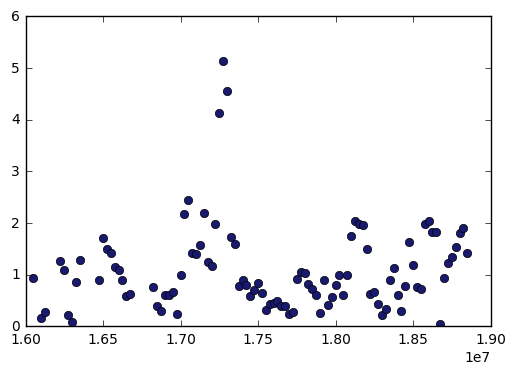

In [27]:
#makes a manhattan plot
import pylab as pl
pos = sets['start'][:n_wnds]
pl.plot(pos, -sp.log10(pv), 'o', color='MidnightBlue')

## Developers

- Francesco Paolo Casale (<casale@ebi.ac.uk>)
- Barbara Rakitsch (<rakitsch@ebi.ac.uk>)
- Danilo Horta (<horta@ebi.ac.uk>)
- Oliver Stegle (<stegle@ebi.ac.uk>)

## References

[1] Casale FP, Rakitsch B, Lippert C, Stegle O. Efficient set tests for the genetic analysis of correlated traits. Nature methods. 2015 Aug 1;12(8):755-8. ([link](http://www.nature.com/nmeth/journal/v12/n8/abs/nmeth.3439.html))